# Cross-validation
In this notebook, all the cross-validation pipeline will be conducted, including imputation
feature selection, preprocessing, modeling and evaluation.

Each process is abstracted and encapsulated in the sklearn.pipline.

In [85]:
from sklearn.preprocessing import RobustScaler
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LassoCV
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_selection import SelectFromModel
from sklearn.pipeline import Pipeline
import numpy as np
import pandas as pd
import shap
import dataclasses
import matplotlib.pyplot as plt
import seaborn as sns

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [86]:
from cycler import cycler
COLORS = [
    "#F27970",
    "#BB9727",
    "#54B345",
    "#32B897",
    "#05B9E2",
    "#8983BF",
    "#C76DA2"
]
plt.rcParams['axes.prop_cycle'] = cycler(color=COLORS)


In [87]:
# read the dataset
dataset = pd.read_csv("dataset.csv")
dataset

,hba1c,fasting_glucose,ldl_c,hdl_c,potassium,age,sex,cls
0,48.420542,10.396515,62.804239,53.761913,97.547678,119.261790,0,3
1,55.683690,15.456625,61.559030,40.332086,NaN,106.126817,1,3
2,39.831635,12.395133,NaN,38.350987,105.142943,20.302342,1,0
3,49.635516,15.406306,58.043979,49.039387,97.863938,30.612104,1,1
4,45.556556,9.939567,NaN,44.502845,105.071941,26.716472,0,0
...,...,...,...,...,...,...,...,...
3469,39.051619,21.729115,62.262828,56.461415,102.231910,92.598590,1,3
3470,48.509847,6.229125,62.404383,NaN,111.272524,29.304836,1,2
3471,43.564022,10.113451,63.850290,51.039572,113.973735,62.774935,0,2
3472,49.782781,17.322241,NaN,44.564655,NaN,87.988899,0,0


In [88]:
# split the dataset
features = dataset.columns.to_list()
features.remove("cls")

X = dataset[features]
y = dataset["cls"]

numerical_cols = ['hba1c', 'fasting_glucose', 'ldl_c', 'hdl_c', 'potassium', 'age']
categorical_cols = ['sex']

#scaling the numerical columns
def scale(X):
    scaler = RobustScaler()
    pipeline=ColumnTransformer([
        ('num',scaler,numerical_cols),
    ])

    X_scaled = pipeline.fit_transform(X)
    return X_scaled, pipeline


## 1. Imputation

In [89]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

def impute(X, n_imputation):
    print("the iteration of imputation is {}".format(n_imputation))
    rr = RandomForestRegressor()
    imputer = IterativeImputer(estimator=rr, verbose=1, max_iter=n_imputation)
    X_imputed = imputer.fit_transform(X)
    return X_imputed, imputer

## 2.Feature selection and preprocessing
we will apply feature selection using Lasso with Grid Search nested cross-validation to locate the optimal
features

In [90]:
def select_features(X, y):

    lasso = LassoCV(cv=5)
    lasso.fit(X, y)
    select_model = SelectFromModel(lasso, prefit=True)

    features_selected = []
    for i, coef in enumerate(lasso.coef_):
        if coef != 0:
            features_selected.append(features[i])
    alpha = lasso.alpha_
    X_selected = select_model.transform(X)
    print("feature selected: ", features_selected)
    return X_selected, features_selected, select_model, alpha

In [91]:
import warnings
warnings.filterwarnings("ignore")

## 3. Model development

In [92]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.metrics import hamming_loss, f1_score, average_precision_score, precision_recall_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
import itertools
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import roc_auc_score, roc_curve
from xgboost import XGBClassifier

In [93]:
from sklearn.base import BaseEstimator, ClassifierMixin
from pydantic import BaseModel
from typing import Any, Dict, List, Tuple
from sklearn.model_selection import KFold
import tensorflow as tf

class TFDNN(BaseEstimator, ClassifierMixin):
    '''
    sklearn compatible version of TensorFlow DNN
    '''

    def __init__(self, p:float=1.0) -> None:
        
    # Create the Sequential model
        self.p = p
        self.model = tf.keras.Sequential([
        # Input layer with a flexible input shape and first hidden layer with 16 units
            tf.keras.layers.Dense(16, activation='relu'),
            tf.keras.layers.Dense(32, activation='relu'),
            tf.keras.layers.Dense(64, activation='relu'),
            tf.keras.layers.Dense(32, activation='relu'),
            tf.keras.layers.Dense(16, activation='relu'),
            tf.keras.layers.Dropout(rate=p),
            tf.keras.layers.Dense(4, activation='softmax')
        ])
        self.model.compile(optimizer="adam", loss=tf.keras.losses.CategoricalCrossentropy(), metrics=[tf.keras.metrics.F1Score(average="weighted")])

    def fit(self, X, y):
        self.model.fit(X, y, batch_size=32, epochs=10)
        
    def predict_prob(self, X):
        return self.model(X)
    
    def predict(self, X):
        return tf.argmax(self.model.predict(X_comp), axis=1)
    

In [94]:
def plot_confusion_matrix(y_pred, y, save_path, classes):
    '''
    Plot the confusion matrix of multi-label classification.
    
    Args:
        y_pred (List[int]): Predicted labels by the model, categorized by 0, 1, 2, 3.
        y (List[int]): Ground truth labels, categorized by 0, 1, 2, 3.
        save_path: the path for saving the result plot.
        classes (List[str]): List of class names corresponding to each label.
    '''
    # Compute confusion matrix
    cm = confusion_matrix(y, y_pred)
    plt.figure(figsize=(8, 6))
    # Normalize confusion matrix
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    plt.imshow(cm, interpolation='nearest', cmap="YlGnBu")
    plt.title('Confusion matrix')
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.savefig("figures/" + save_path + ".svg", format="svg", dpi=1400)
    # plt.show()

def plot_auc(y_pred, y, save_path, classes):
    '''
    Plot the one-versus-rest AUC curve.
    
    Args:
        y_pred predict probability of each class
        y (List[int]): Ground truth labels, categorized by 0, 1, 2, 3.
        classes (List[str]): List of class names corresponding to each label.
    '''
    lb = LabelBinarizer()
    lb.fit(y)
    y_bin = lb.transform(y)

    plt.figure(figsize=(8, 6))
    for i in range(len(classes)):
        auc = roc_auc_score(y_bin[:, i], y_pred[:, i])
        fpr, tpr, _ = roc_curve(y_bin[:, i], y_pred[:, i])
        plt.plot(fpr, tpr, lw=2, label='%s (AUC = %0.2f)' % (classes[i], auc))

    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('1 - Specificity')
    plt.ylabel('Sensitivity')
    plt.title('One-vs-Rest ROC AUC Curve')
    plt.legend(loc="lower right")
    plt.savefig("figures/" + save_path + ".svg", dpi=1400, format="svg")

def plot_precision_recall_curve(recalls, precisions, save_path, classes):
    '''
    Args:
        recalls: shape [n_classes, n_scatter]
        precisions:shape [n_classes, n_scatter]
    '''
    plt.figure(figsize=(8, 6))
    for i,(recall, precision) in enumerate(zip(recalls, precisions)):
        plt.plot(recall, precision, lw=2, label=classes[i])

    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel("recall")
    plt.ylabel("precision")
    plt.legend(loc="best")
    plt.title("precision vs. recall curve")
    plt.savefig("figures/" + save_path + ".svg", format="svg", dpi=1400)


For the iteration: 0 ##############################
the iteration of imputation is 10
[IterativeImputer] Completing matrix with shape (250, 6)
[IterativeImputer] Change: 0.7032047965419548, scaled tolerance: 0.0011299916149060207 
[IterativeImputer] Change: 0.6368280839549738, scaled tolerance: 0.0011299916149060207 
[IterativeImputer] Change: 0.7049564595812003, scaled tolerance: 0.0011299916149060207 
[IterativeImputer] Change: 0.4461848262662458, scaled tolerance: 0.0011299916149060207 
[IterativeImputer] Change: 0.4419195875940724, scaled tolerance: 0.0011299916149060207 
[IterativeImputer] Change: 0.4725838913738731, scaled tolerance: 0.0011299916149060207 
[IterativeImputer] Change: 0.4949093947662285, scaled tolerance: 0.0011299916149060207 
[IterativeImputer] Change: 0.38818789091136097, scaled tolerance: 0.0011299916149060207 
[IterativeImputer] Change: 0.4355864054879227, scaled tolerance: 0.0011299916149060207 
[IterativeImputer] Change: 0.5276867829599405, scaled tolerance:

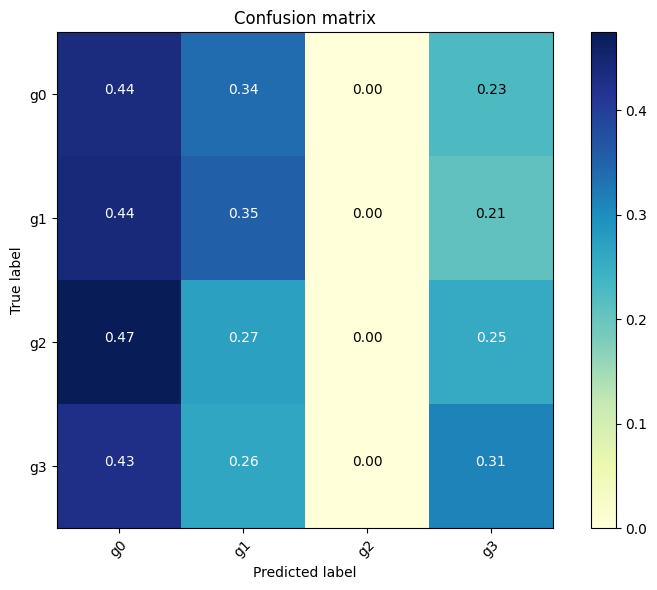

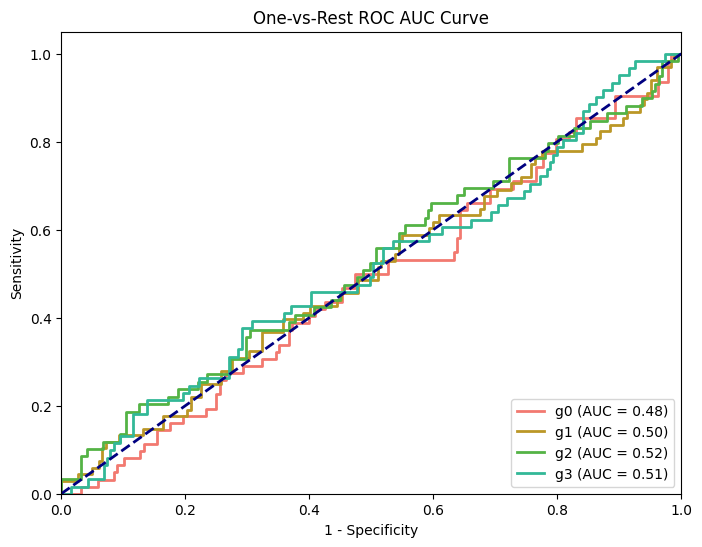

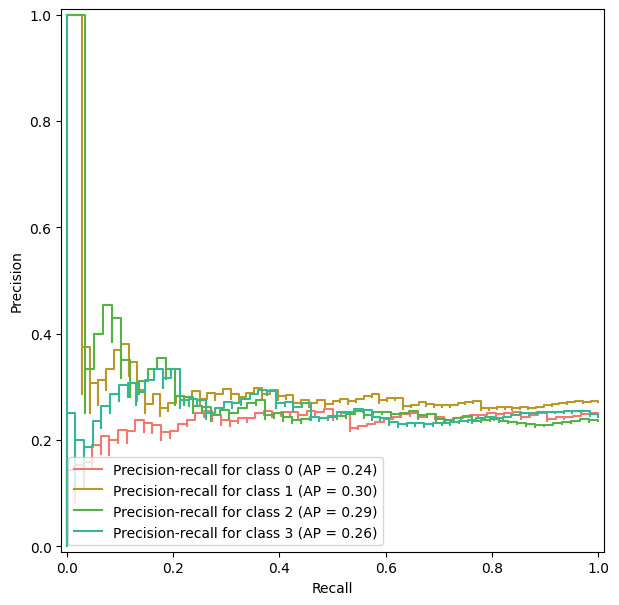

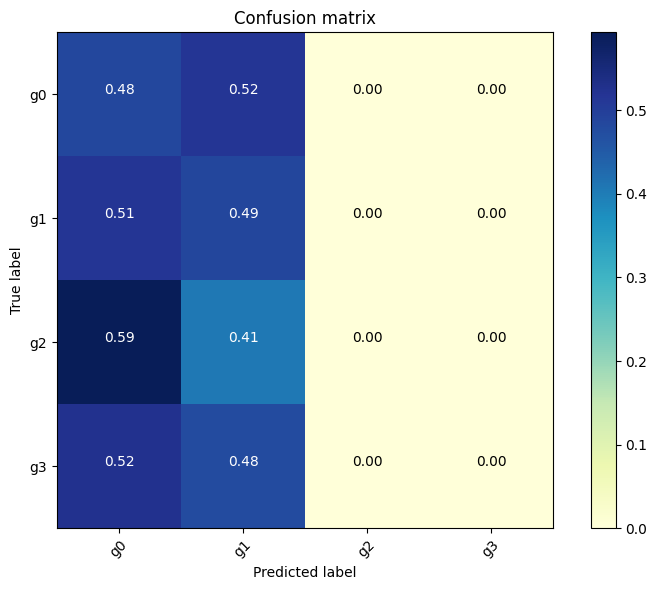

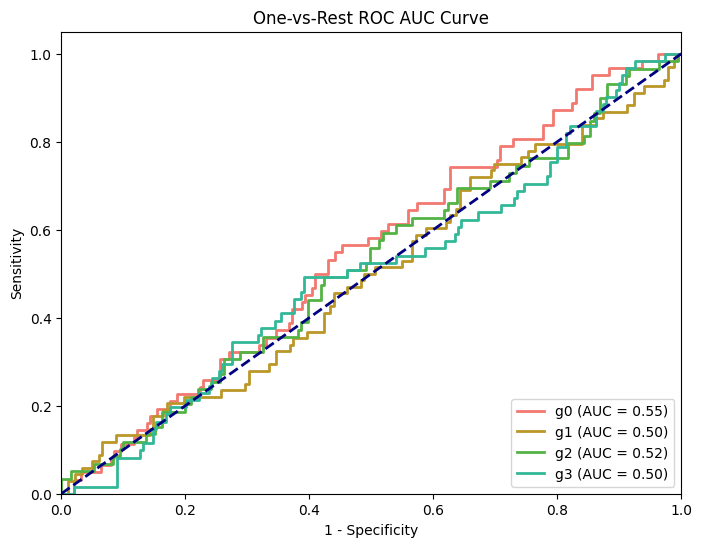

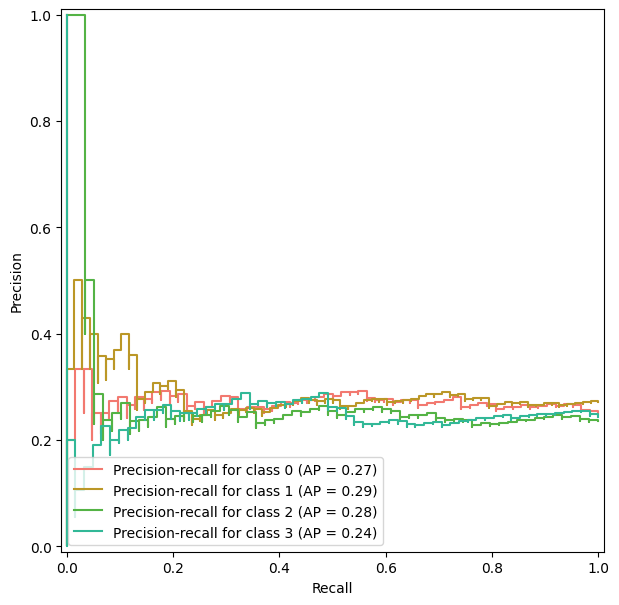

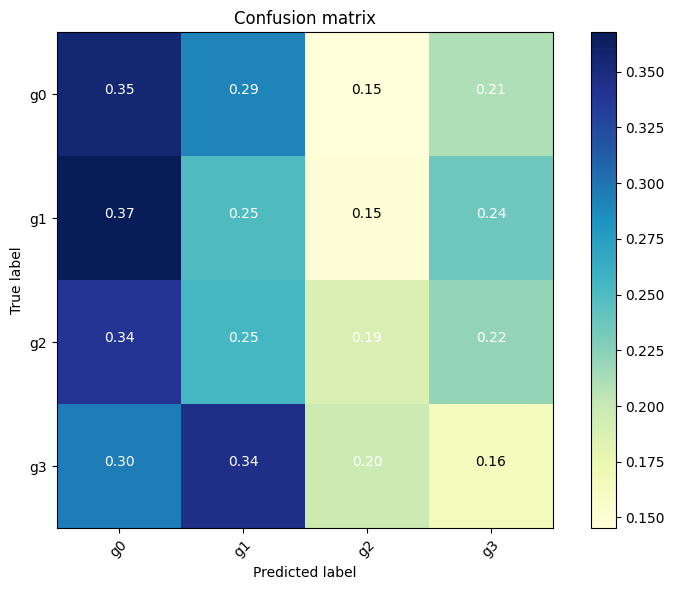

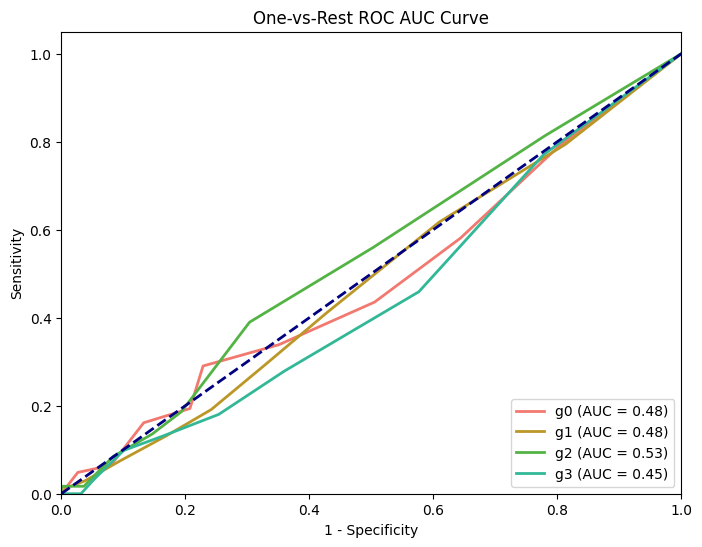

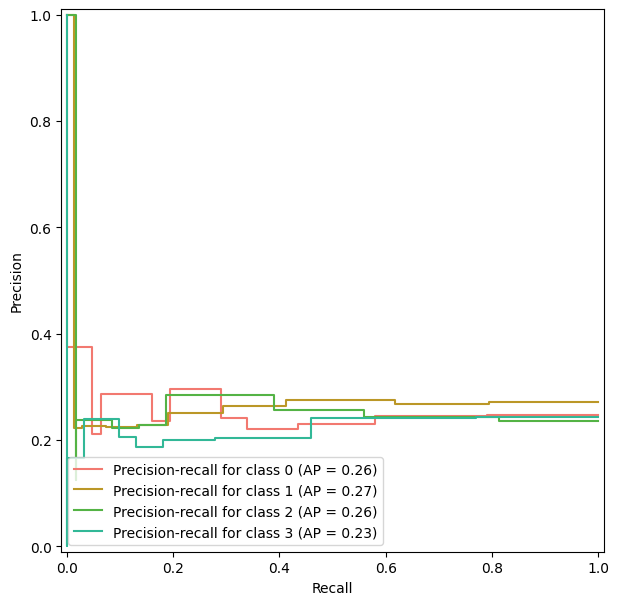

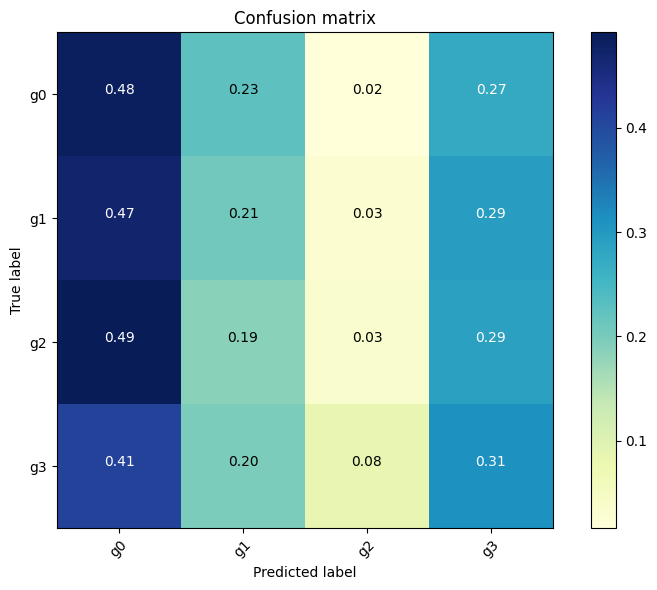

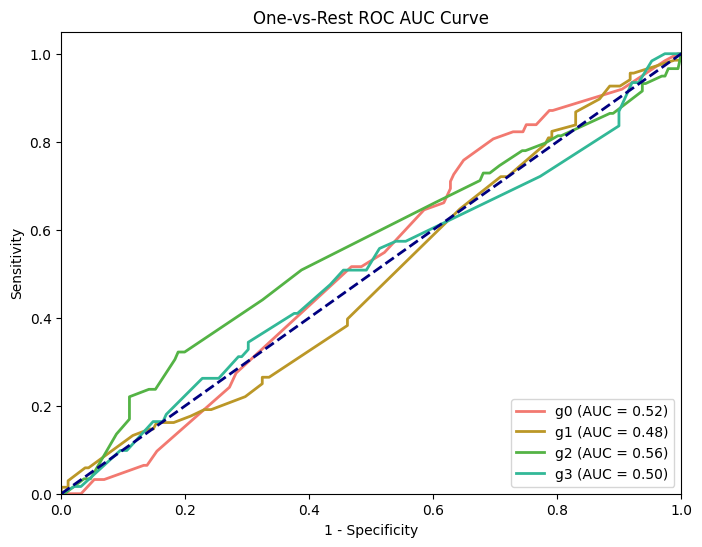

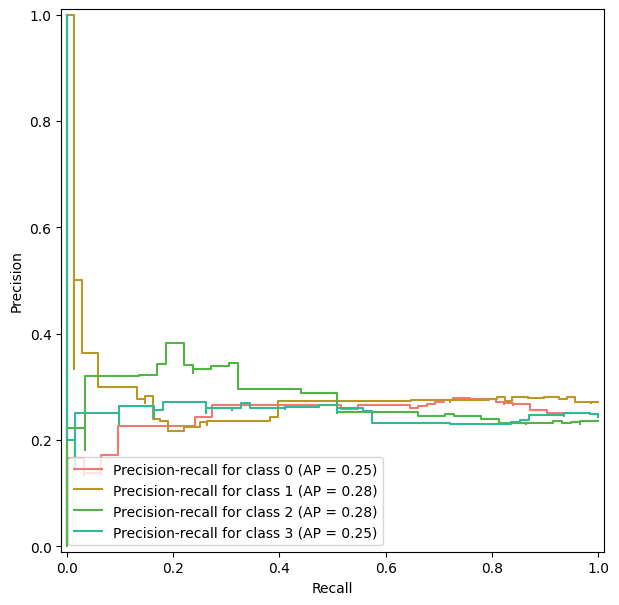

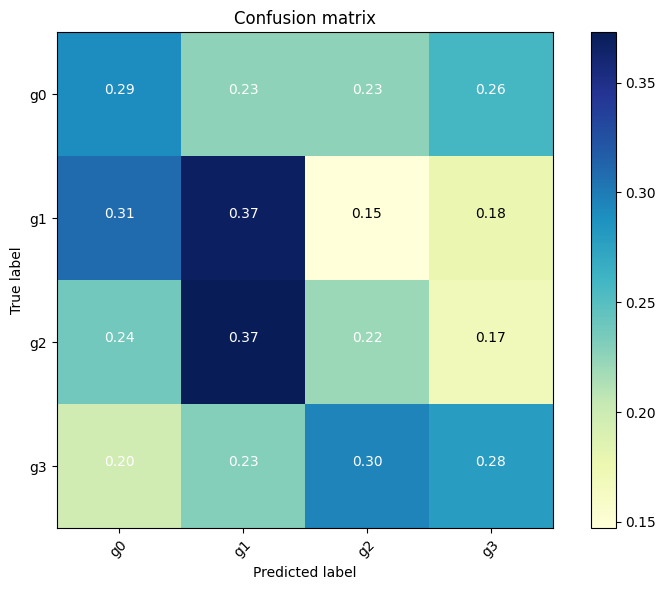

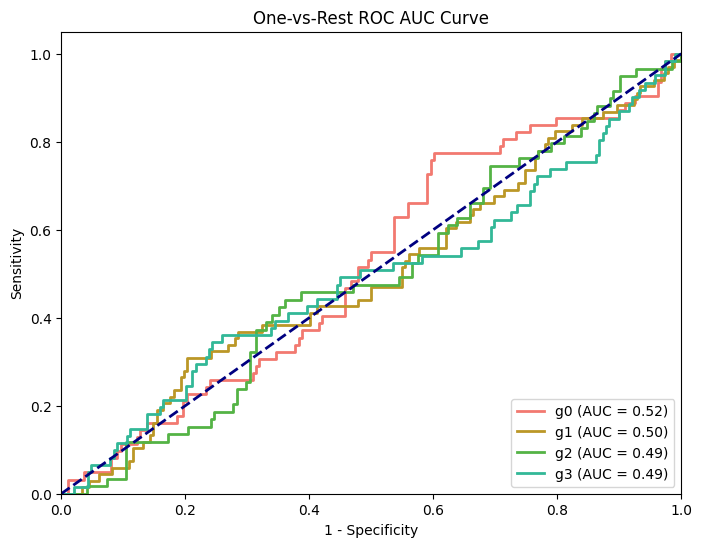

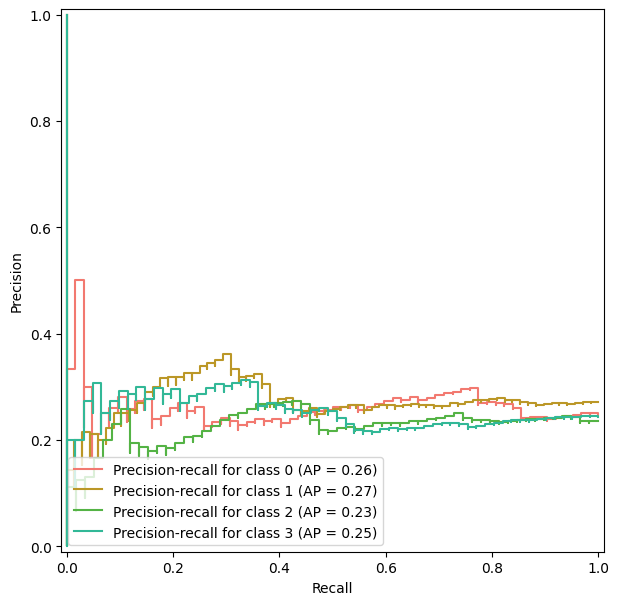

For the iteration: 1 ##############################
the iteration of imputation is 10
[IterativeImputer] Completing matrix with shape (250, 6)
[IterativeImputer] Change: 0.8552010195854987, scaled tolerance: 0.0012988377423528855 
[IterativeImputer] Change: 0.53682571404451, scaled tolerance: 0.0012988377423528855 
[IterativeImputer] Change: 0.3738080762662205, scaled tolerance: 0.0012988377423528855 
[IterativeImputer] Change: 0.33557576054688465, scaled tolerance: 0.0012988377423528855 
[IterativeImputer] Change: 0.3598695476876761, scaled tolerance: 0.0012988377423528855 
[IterativeImputer] Change: 0.32046607445075703, scaled tolerance: 0.0012988377423528855 
[IterativeImputer] Change: 0.39445737023475036, scaled tolerance: 0.0012988377423528855 
[IterativeImputer] Change: 0.39192361110090007, scaled tolerance: 0.0012988377423528855 
[IterativeImputer] Change: 0.4054908191695347, scaled tolerance: 0.0012988377423528855 
[IterativeImputer] Change: 0.7043728274028045, scaled tolerance

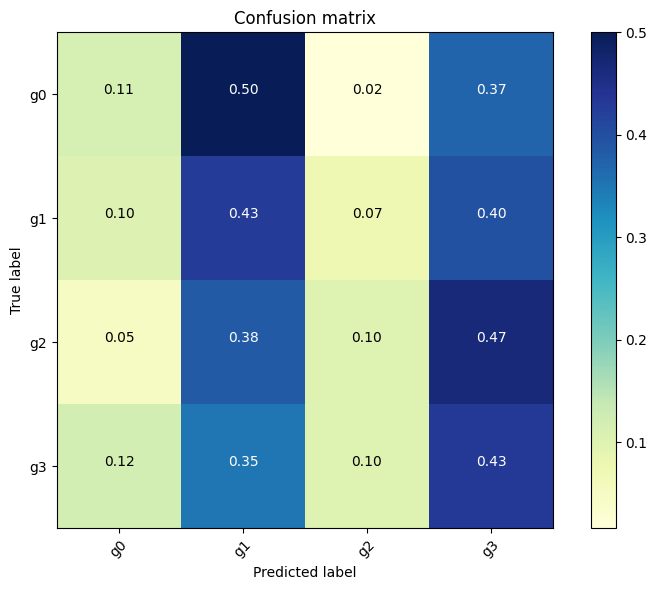

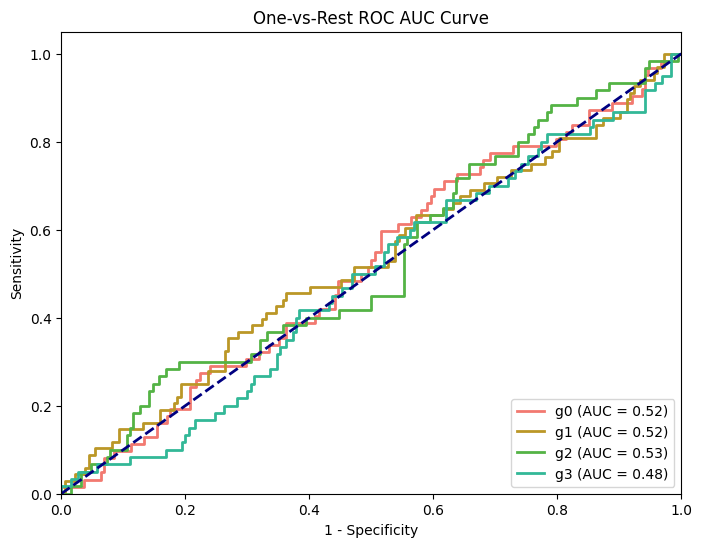

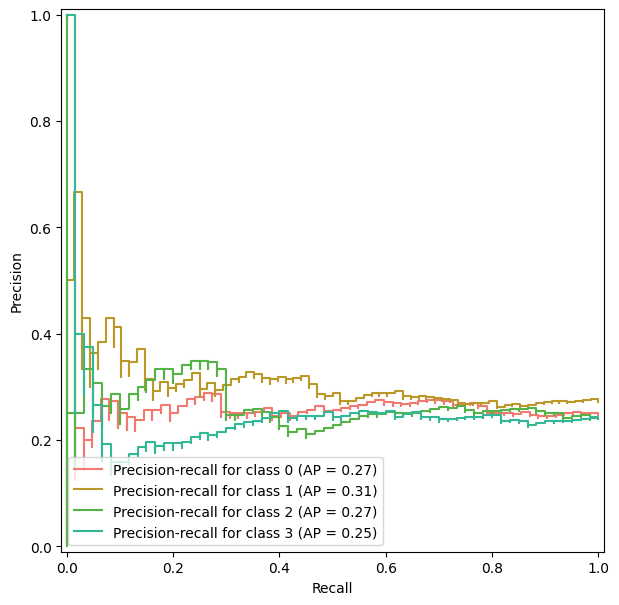

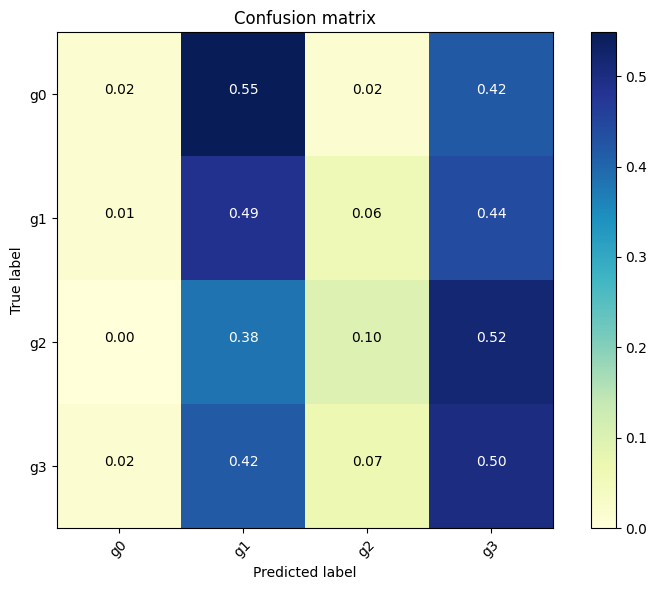

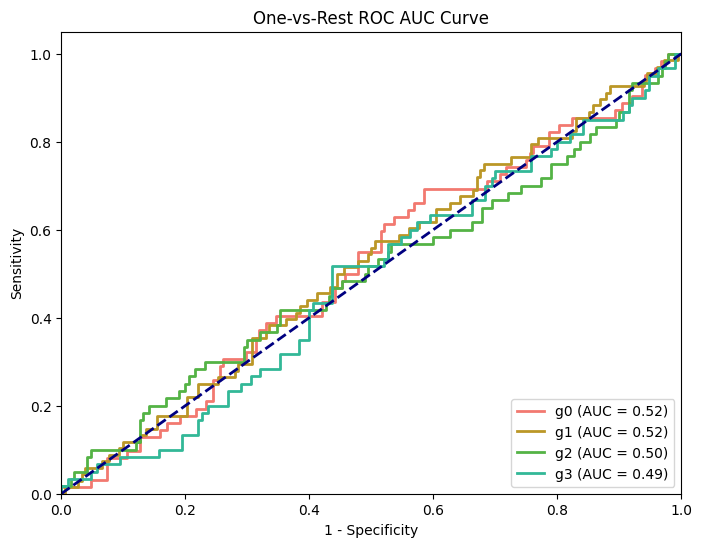

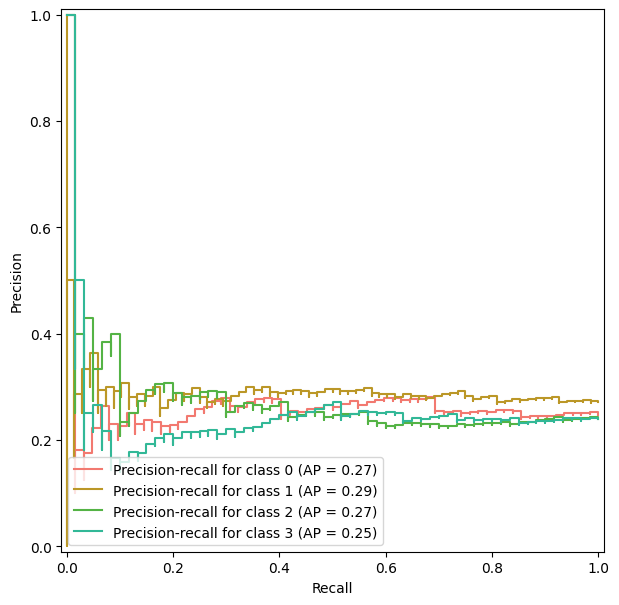

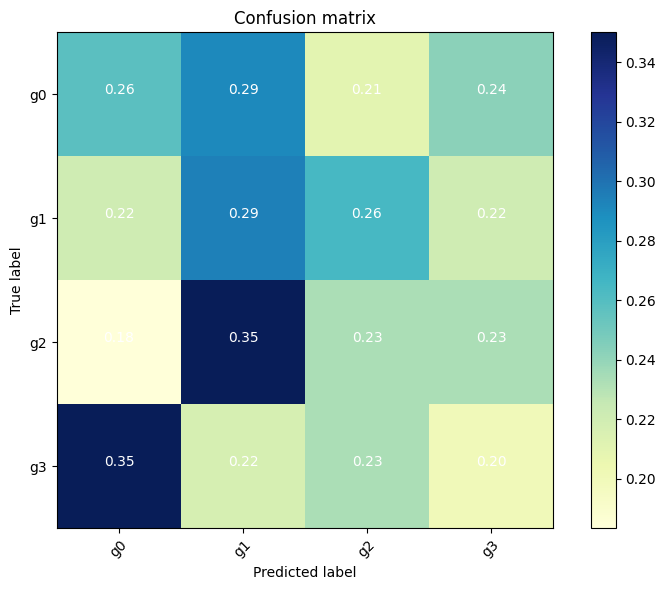

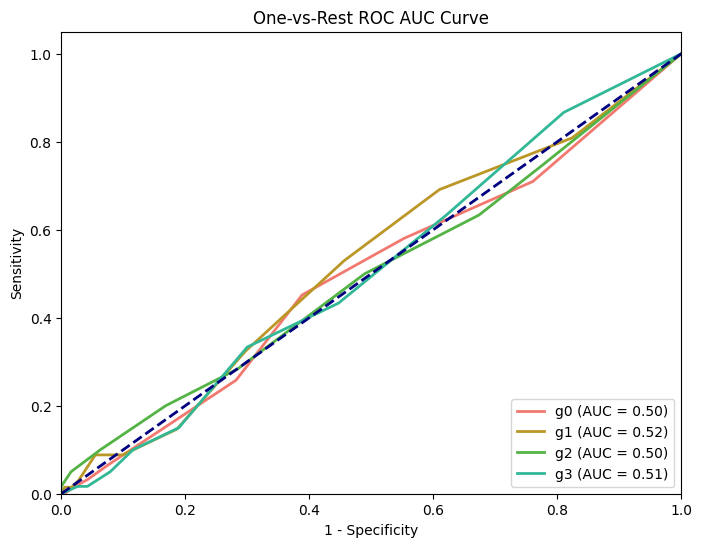

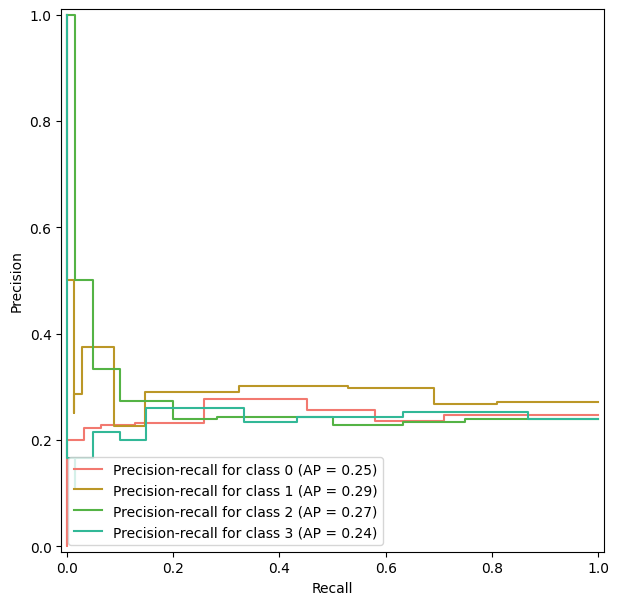

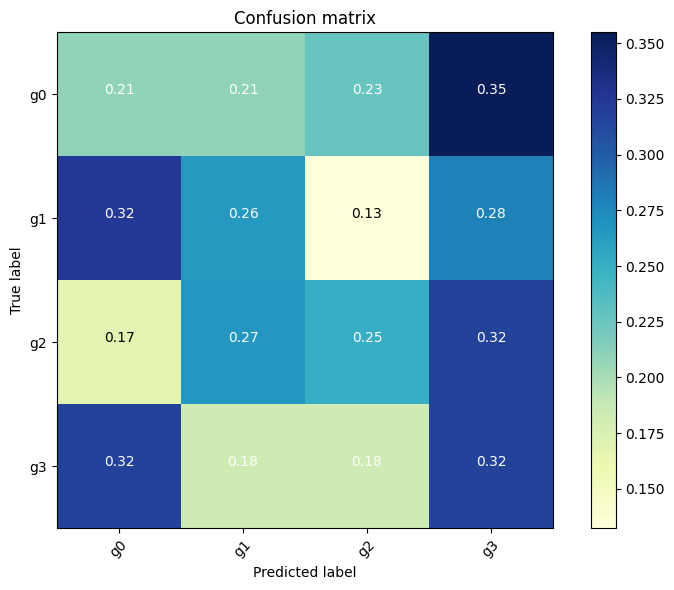

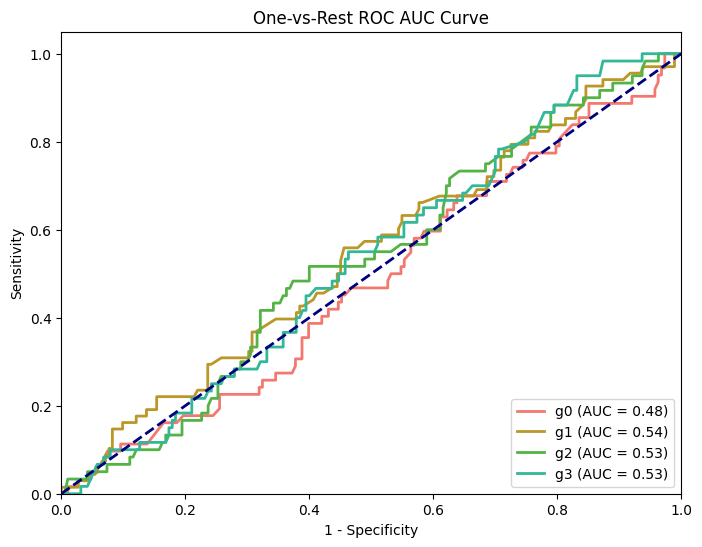

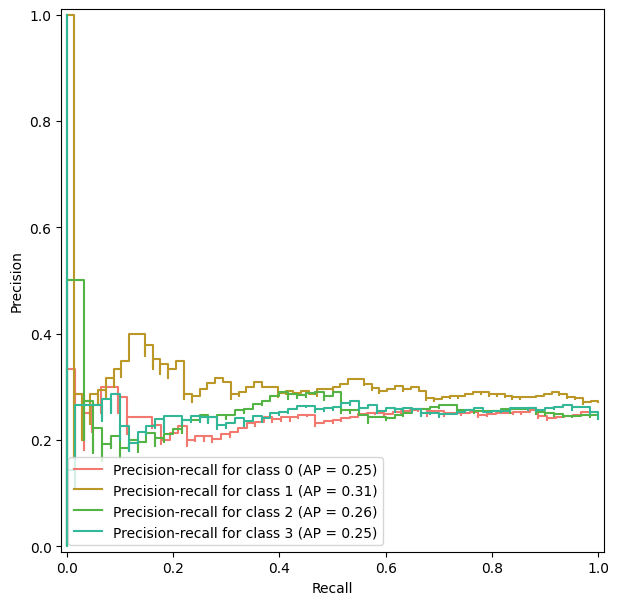

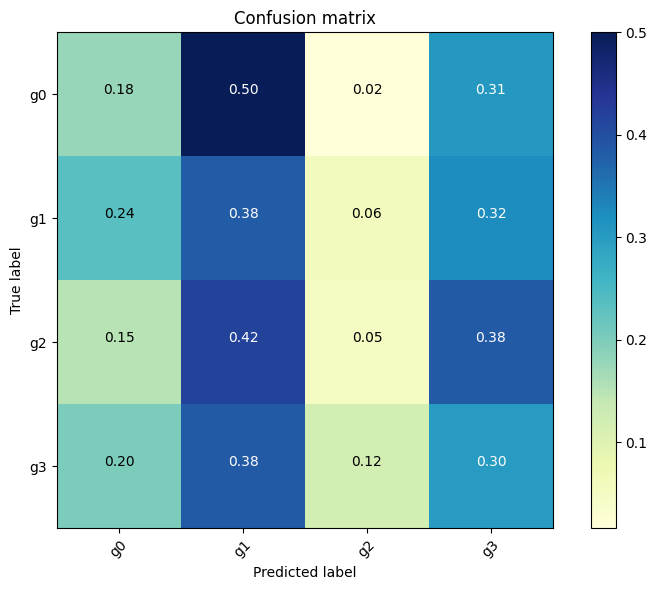

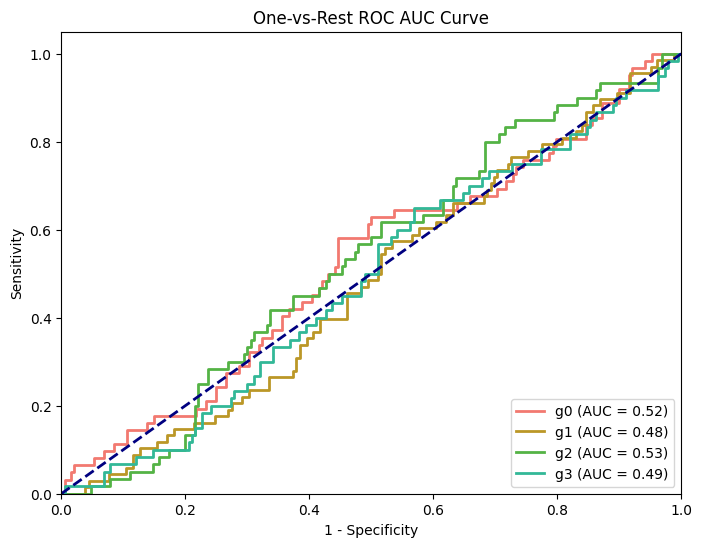

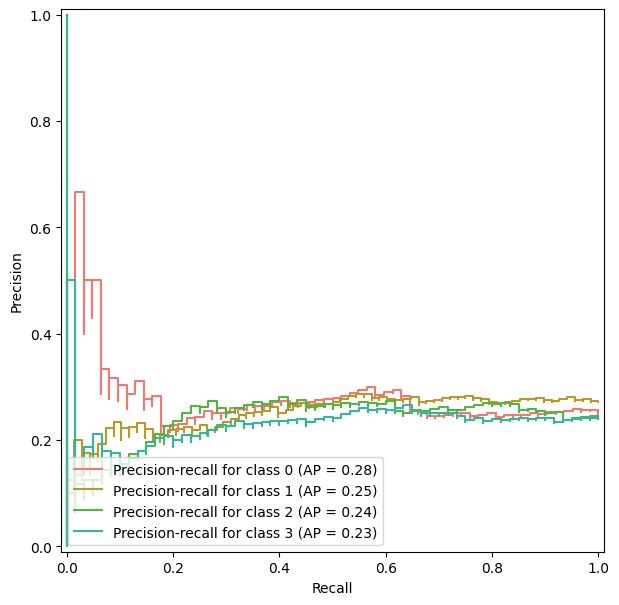

In [95]:
from sklearn.metrics import (precision_recall_curve,
                             PrecisionRecallDisplay)
models = [
    {
        "name": "lr",
        "estimator": LogisticRegression,
        "params": {"penalty": ["l1", "l2"], "C":[0.01, 0.1, 1, 10, 100, 1000],'solver':['liblinear']}
    },
    {
        "name": "svm",
        "estimator": SVC,
        "params": {"C":[0.01, 0.1, 1, 10, 100, 1000],'kernel': ['rfb', 'linear'], "probability":[True]}
    },
    {
        "name": "rfc",
        "estimator": RandomForestClassifier,
        "params": {"n_estimators": [10, 100, 1000], "criterion": ["gini", "entropy", "log_loss"]}
    },
    {
        "name": "xgboost",
        "estimator": XGBClassifier,
        "params": {"learning_rate": [1e-1, 1e-2, 1e-3,], "max_depth":[3, 4, 6], "n_estimators": [10, 100, 100]}
    },
    {
        "name": "dnn",
        "estimator": MLPClassifier,
        "params": {"hidden_layer_sizes":[[16,32,64,32,16], [16,32,32]],"learning_rate_init": [1e-2, 1e-3, 1e-4, 1e-5]}
    }

]

result = {
        "alpha":[],
        "features_selected": [],
        "test_set": [],
        "training_set": []
    }
for model in models:
    result.update({
        model["name"]: {
                "hamming_loss": [],
                "f1_macro": [],
                "f1_weighted": [],
                "precision0":[],
                "precision1":[],
                "precision2":[],
                "precision3":[],
                "recall0": [],
                "recall1": [],
                "recall2": [],
                "recall3": [],
                "average_precision0": [],
                "average_precision1": [],
                "average_precision2": [],
                "average_precision3": [],
                "tpr0": [],
                "tpr1": [],
                "tpr2": [],
                "tpr3": [],
                "fpr0": [],
                "fpr1": [],
                "fpr2": [],
                "fpr3": [],
                "auc0": [],
                "auc1": [],
                "auc2": [],
                "auc3": [],
                "cache": []
            }
    })
classes = ["g0", "g1", "g2", "g3"]

def train(X, y, models):
    best_estimators = {}
    for model in models:
        params = model["params"]
        name = model["name"]
        # Grid search for the parameters
        # use weighted score to take the imbalance into account
        gs = GridSearchCV(model["estimator"](), cv=2, param_grid=params, scoring="f1_weighted") 
        gs.fit(X, y)
        best_estimators[name] = {
            "estimator": gs.best_estimator_,
            "params": gs.best_params_
        }
    return best_estimators

def evaluate(estimator, X_test, y_test, eval_result, iter_num):
    model_name = estimator.__class__.__name__
    y_test_pred = estimator.predict(X_test)
    y_test_pred_prob = estimator.predict_proba(X_test)
    eval_result["hamming_loss"].append(hamming_loss(y_pred =y_test_pred, y_true=y_test))

    lb = LabelBinarizer()
    lb.fit(y_test)
    y_bin = lb.transform(y_test)
    f1_macro = f1_score(y_true=y_test, y_pred=y_test_pred, average='macro')
    f1_weighted = f1_score(y_true=y_test, y_pred=y_test_pred, average='weighted')
    eval_result["f1_macro"].append(f1_macro)
    eval_result["f1_weighted"].append(f1_weighted)
    eval_result["cache"].append(estimator)
    
    # plot metrics
    file_name = model_name + f"-Iter-{iter_num}"
    plot_confusion_matrix(y_test_pred, y_test, file_name + "-ConfusionMatrix", classes)

    plot_auc(y_test_pred_prob, y_test, file_name + "-AUC", classes)
    _, ax = plt.subplots(figsize=(7, 8))
    for i in range(len(classes)):
        fpr, tpr, _ = roc_curve(y_bin[:, i], [pred[i] for pred in y_test_pred_prob])
        eval_result[f"fpr{i}"].append(fpr)
        eval_result[f"tpr{i}"].append(tpr)
        auc = roc_auc_score(y_bin[:, i], [pred[i] for pred in y_test_pred_prob])
        eval_result[f"auc{i}"].append(auc)

        precision, recall, _ = precision_recall_curve(y_bin[:, i], y_test_pred_prob[:, i])
        average_precision = average_precision_score(y_bin[:, i], y_test_pred_prob[:, i])
        eval_result[f"precision{i}"].append(precision)
        eval_result[f"recall{i}"].append(recall)
        eval_result[f"average_precision{i}"].append(average_precision)
        display = PrecisionRecallDisplay(
            recall=recall,
            precision=precision,
            average_precision=average_precision,
        )
        display.plot(ax=ax, name=f"Precision-recall for class {i}", color=COLORS[i])
    plt.show()
    # new added
    # recalls = [eval_result[f"recall{i}"][iter_num] for i in range(4)]
    # precisions = [eval_result[f"precision{i}"][iter_num] for i in range(4)]
    # plot_precision_recall_curve(recalls, precisions, file_name + "-precision_recall_curve", classes)
        

def cross_validate(X, y, n_splits):
    '''
    cross-validate the models
    '''
    kf = StratifiedKFold(n_splits=n_splits)
    

    for iter, (train_index, test_index) in enumerate(kf.split(X, y)):
        print("For the iteration: {}".format(iter), "#" * 30)
        X_train = X.loc[train_index]
        y_train = y.loc[train_index]
        X_test = X.loc[test_index]
        y_test = y.loc[test_index]
        
        X_train_scaled, scaler = scale(X_train)

        n_imputation = dataset[features].isnull().mean().mean() * 100 // 1
        n_imputation = int(n_imputation)
        X_train_imputed, imputer = impute(X_train_scaled, n_imputation)
        
        X_train_selected, features_selected, selector, alpha = select_features(X_train_imputed, y_train)
 
        best_estimators = train(X_train_selected, y_train, models)
        result["features_selected"].append(features_selected)
        result["alpha"].append(alpha)
        ### evaluate
        
        for process in [scaler, imputer, selector]:
            X_test = process.transform(X_test)

        # get the reference of the current test_set
        result["test_set"].append((X_test, y_test))
        result["training_set"].append((X_train_selected, y_train))
        # evaluate the metrics for each iteration
        for name, value in best_estimators.items():
            evaluate(estimator=value["estimator"], X_test=X_test, y_test=y_test, eval_result=result[name], iter_num=iter)
                

cross_validate(X.head(500), y.head(500), 2)

## Do some housework

collect the data and write to disk

In [96]:
import scipy.stats as st 


def CI(samples, alpha = 0.95):
    mean = np.mean(samples)
    left, right = st.norm.interval(confidence = alpha, loc = mean, scale = st.sem(np.array(samples)))
    res = [left , mean, right]
    func = lambda x : "{}%".format(round(x * 100, 2))
    return list(map(func, res))


model_names = [item["name"] for item in models]
performances = {
    "model": [],
    "f1_macro":[],
    "f1_weighted": [],
    "hamming_loss": [],
    "auc0": [],
    "auc1": [],
    "auc2": [],
    "auc3": [],
}

for name in model_names:
    performances["model"].append(name)
    for metric in performances.keys():
        if metric == "model":
            continue
        samples = result[name][metric]
        ci = CI(samples)
        performances[metric].append(ci)

performances_df = pd.DataFrame(performances)
performances_df.to_csv("csv/model_performace.csv")

## Model Selection
Need to select features set first, then compare the model performance(over cross-validation) to find the most optimal model.

### Select the optimum features set

In [97]:
# find the optimum based on alpha, need to check the 
optimum_index = np.argmin(result["alpha"])

### Save model

In [98]:
import pickle
# take rfc for example
optimal_model = result["rfc"]["cache"][optimum_index]

def save_model(file_name: str, model):
    with open("models/"+file_name,'wb') as f:
        pickle.dump(model,f)
save_model("rfc.pkl", optimal_model)

In [112]:
result

{'alpha': [0.02463037106256278, 0.03852914174865254],
 'features_selected': [['hba1c', 'potassium'], ['fasting_glucose', 'hdl_c']],
 'test_set': [(array([[-2.96778187e-02, -7.05198881e-01],
          [ 6.78538701e-01, -3.42949543e-02],
          [-8.67166720e-01,  2.16634335e-04],
          [ 8.87920884e-02, -6.75826080e-01],
          [-3.08939971e-01, -6.37776466e-03],
          [ 8.19207016e-01,  5.35537487e-01],
          [ 2.02590894e-01,  8.91237199e-01],
          [-8.42536186e-01,  1.85068769e-01],
          [ 6.17649688e-01, -5.40070990e-02],
          [ 9.03102287e-01, -3.35019777e-01],
          [-8.77519437e-01,  7.33085414e-01],
          [-1.80247110e-02,  8.55551650e-02],
          [-3.31842179e-01,  8.72476183e-02],
          [-6.58627447e-01, -5.16137775e-01],
          [ 3.58849425e-01, -5.22312966e-01],
          [-1.00040171e-01, -4.39799685e-01],
          [-1.83296265e-01, -7.71194424e-01],
          [-1.75783500e-01, -3.62036889e-01],
          [-5.96552925e-02, 

### Interpretation

Use shap package to quantify and visualize the feature importance

In [99]:
import shap

In [100]:
# need to choose the best model, here just use lr as an example
estimator = result["lr"]["cache"][optimum_index]
X_test_optimal, y_test_optimal = result["test_set"][optimum_index]
X_test_optimal = pd.DataFrame(X_test_optimal, columns=result["features_selected"][optimum_index])
explainer = shap.KernelExplainer(estimator.predict_proba, X_test_optimal)

Using 250 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


In [101]:
shap_values = explainer(X_test_optimal)

  0%|          | 0/250 [00:00<?, ?it/s]

In [102]:
result["features_selected"][optimum_index]
result["features_selected"][optimum_index]

['hba1c', 'potassium']

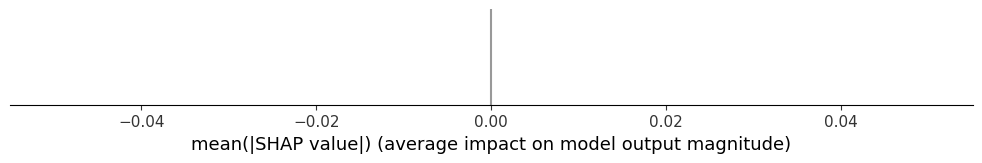

In [103]:
classes = ["g0", "g1", "g2", "g3"]
values_list = [shap_values[:, :, cls_ind] for cls_ind in range(len(classes))]
shap.summary_plot(values_list, feature_names=result["features_selected"][optimum_index],plot_type="bar", show=False, plot_size=0.5)
plt.gcf().set_size_inches(10, 2)
plt.legend().set_visible(False)

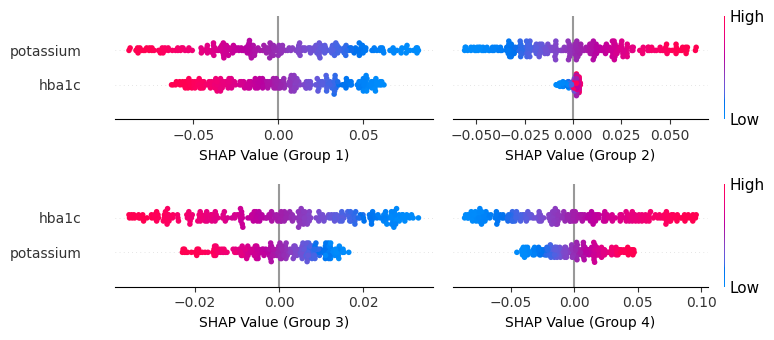

In [104]:
def plot_shap_beeswarm(values_list, features):
    # Setting figure size and DPI for high-resolution outputs
    fig = plt.figure(figsize=(12, 42))
    
    for i in range(4):
        plt.subplot(2, 2, i + 1)
        # Generate SHAP beeswarm plot
        ax = shap.plots.beeswarm(values_list[i], show=False, color_bar= i%2 != 0, plot_size=1, color_bar_label="").axes
        
        # Set axis labels and title
        ax.set_xlabel(f"SHAP Value (Group {i + 1})", fontsize=10)
        
        # Set y-axis labels
        if i % 2 != 0:
            ax.set_yticklabels(["" for _ in features])

        # Adjusting tick parameters for better visibility
        ax.tick_params(axis='both', which='major', labelsize=10)
        plt.subplots_adjust(left=0.3, right=0.9, top=0.95, bottom=0.05, hspace=1)
    # Adjust layout to prevent overlapping
    plt.tight_layout()
    plt.savefig("figures/beeswarm.svg", format="svg", dpi=1400)

plot_shap_beeswarm(values_list, result["features_selected"][optimum_index])
        

Color is used to display the original value of a feature

## Model Calibration
The model calibration transform the output probability of a model to align with the actual event probability of each class. In this case, we want the calibration to follow some rules:

1. The calibration function should minimize a strictly proper scoring rule. Strictly proper scoring rules are loss functions such that the unique minimizer is the true probability distribution. Log-loss and quadratic loss are two such examples. This ensures that with enough data our calibration function converges to the true probabilities:  p^=Pr(Y|p^).

2. The calibration function should be strictly monotonic. It doesn’t feel intuitive to flip predictions if the model suggests one is more likely. Additionally, a monotonic calibration function preserves the ranking of predictions: this means that AUC isn’t affected (indeed you can estimate AUC and train your calibration function on the same data: more on that later).

3. The calibration function should be flexible. Miscalibration may not fit a specific parametric form so we need a non-parametric model.

4. The calibration function needs to be trained on independent data. Otherwise you might be vulnerable to extreme overfitting: your model could be too confident predicting close to zero and one and then your calibration function makes it even more overconfident.

### Reliability curve
x-axis represents the average predicted probability in each bin

y-axis is then the fraction of positives given the predictions of that bin

References:

[1]https://scikit-learn.org/stable/modules/calibration.html#probability-calibration

[2]https://www.unofficialgoogledatascience.com/2021/04/why-model-calibration-matters-and-how.html

In [105]:
X_test, y_test = result["test_set"][optimum_index]

In [106]:
from sklearn.calibration import CalibratedClassifierCV
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

from sklearn.calibration import CalibrationDisplay

optimum_model = result["rfc"]["cache"][optimum_index]
optimum_model


RandomForestClassifier(criterion='entropy', n_estimators=10)

In [107]:
cal_clf_sigmoid = CalibratedClassifierCV(optimum_model, method="sigmoid", cv="prefit")
cal_clf_isotonic = CalibratedClassifierCV(optimum_model, method="isotonic", cv="prefit")
cal_clf_sigmoid.fit(X_test, y_test)
cal_clf_isotonic.fit(X_test, y_test)

CalibratedClassifierCV(cv='prefit',
                       estimator=RandomForestClassifier(criterion='entropy',
                                                        n_estimators=10),
                       method='isotonic')

In [108]:
cal_clf_isotonic.predict_proba(np.random.randn(1, 2))

array([[0.22789513, 0.26404894, 0.26920112, 0.23885481]])

In [115]:
clf_list = [
    (optimum_model, "Original model"),
    (cal_clf_sigmoid, " Platt scaling"),
    (cal_clf_isotonic, "Isotonic regression"),
]

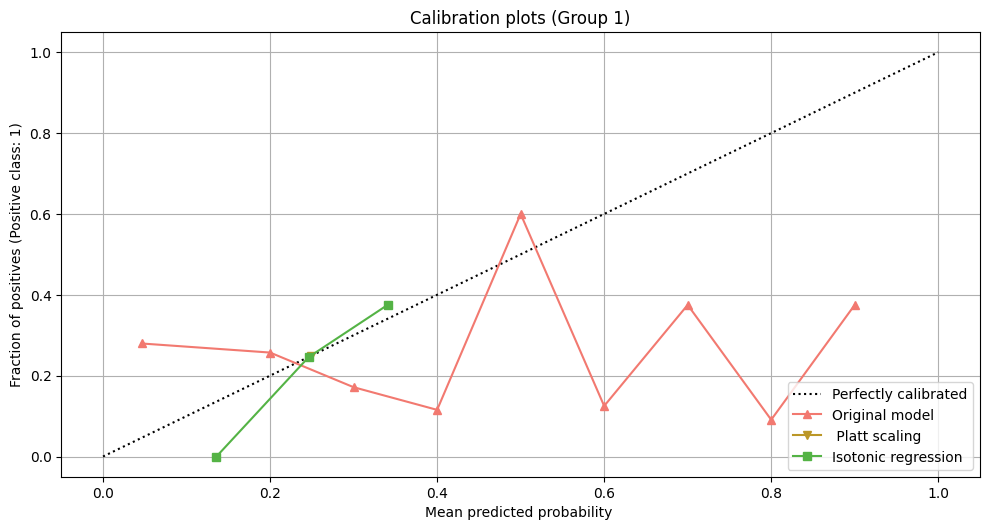

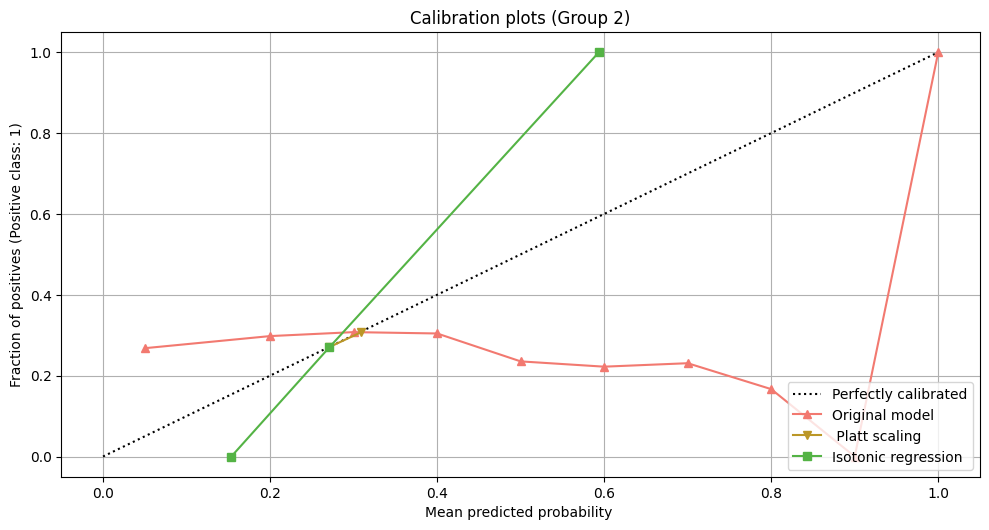

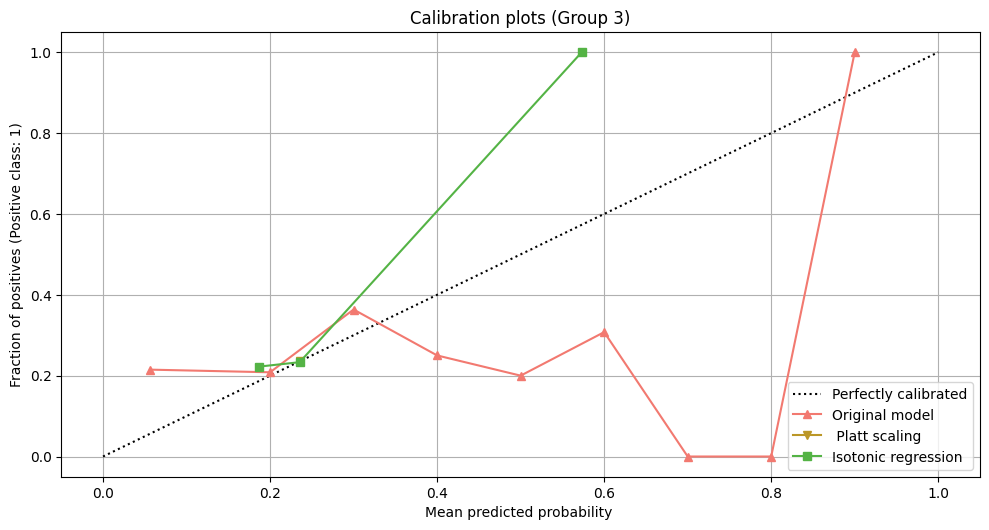

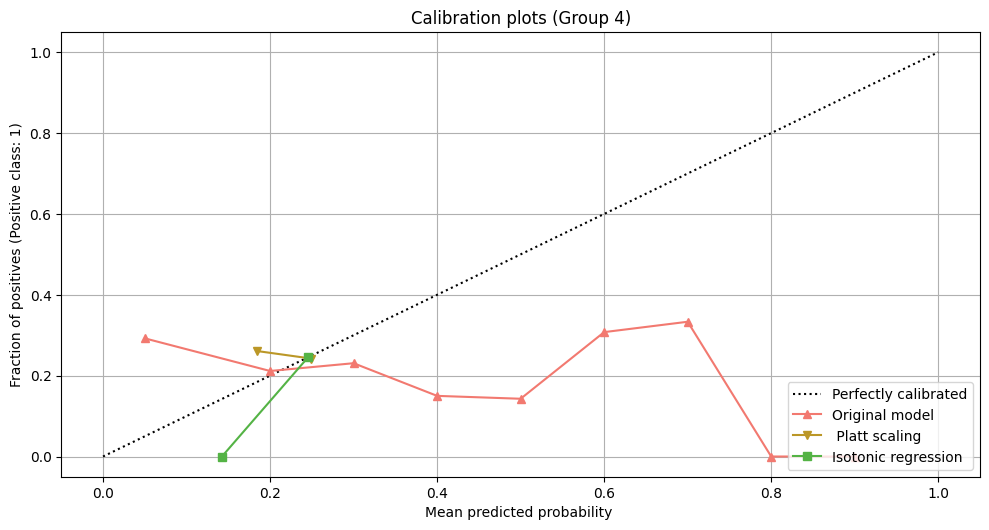

In [116]:
for j in range(4):
    fig = plt.figure(figsize=(10, 10))
    gs = GridSpec(4, 2)

    ax_calibration_curve = fig.add_subplot(gs[:2, :2])
    calibration_displays = {}
    markers = ["^", "v", "s", "o"]

    for i, (clf, name) in enumerate(clf_list):
        y_pred = clf.predict_proba(X_test)[:, j]
        display = CalibrationDisplay.from_predictions(
            (y_test == j).astype(int),
            y_pred,
            n_bins=10,
            name=name,
            ax=ax_calibration_curve,
            color=COLORS[i],
            marker=markers[i],
        )
        plt.xlabel(f"Mean predicted probability ")
        calibration_displays[name] = display

    ax_calibration_curve.grid()
    ax_calibration_curve.set_title(f"Calibration plots (Group {j+1})")

    # # Add histogram
    # grid_positions = [(2, 0), (2, 1), (3, 0), (3, 1)]
    # for i, (_, name) in enumerate(clf_list):
    #     row, col = grid_positions[i]
    #     ax = fig.add_subplot(gs[row, col])

    #     ax.hist(
    #         calibration_displays[name].y_prob,
    #         range=(0, 1),
    #         bins=10,
    #         label=name,
    #         color=COLORS[i],
    #     )
    #     ax.set(title=name, xlabel="Mean predicted probability", ylabel="Count")

    plt.tight_layout()
    plt.show()

## Risk Score

Patients classified in the group 1 are more prone to progress to T2DM according to the model and thus the risk stratification is essential for the patients as a reasonable risk stratification facilitate the decision-making and early prevention of diabetic complications.

The risk score stratification is developed as following the steps:
1. 